In [1]:
import matplotlib.pyplot as plt
import json
from statistics import mean

In [15]:
def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def extract_scores(entry, model_key):
    """
    Retorna um dicionário padronizado de scores
    """
    temp = entry["judge_evaluation"]
    if(model_key in temp.keys()):
        scores = entry["judge_evaluation"][model_key]
        return {
            "factual_correctness": scores["factual_correctness"],
            "instruction_adherence": scores["instruction_adherence"],
            "clarity_and_usefulness": scores["clarity_and_usefulness"],
            "total": scores["total"],
        }

In [18]:
def compute_stats(data, model_key):
    metrics = {
        "factual_correctness": [],
        "instruction_adherence": [],
        "clarity_and_usefulness": [],
        "total": [],
    }

    for entry in data:
        scores = extract_scores(entry, model_key)
        if scores is None:
            continue
        for k in metrics:
            metrics[k].append(scores[k])

    return {k: mean(v) for k, v in metrics.items()}

if __name__ == "__main__":
    data = load_json("llm_judge_results.json")

    stats_a = compute_stats(data, "model_a")
    stats_b = compute_stats(data, "model_b")

    print("GPT-2 Fine-tuned (Model A)")
    for k, v in stats_a.items():
        print(f"{k}: {v:.2f}")

    print("\nGPT-2 Sem Fine-tuning (Model B)")
    for k, v in stats_b.items():
        print(f"{k}: {v:.2f}")

GPT-2 Fine-tuned (Model A)
factual_correctness: 3.79
instruction_adherence: 4.12
clarity_and_usefulness: 4.15
total: 12.06

GPT-2 Sem Fine-tuning (Model B)
factual_correctness: 1.37
instruction_adherence: 1.54
clarity_and_usefulness: 1.48
total: 4.39


In [20]:
def compute_win_rate(data):
    wins = {"A": 0, "B": 0, "Tie": 0}

    for entry in data:
        winner = entry["judge_evaluation"].get("winner", "Tie")
        if winner in wins:
            wins[winner] += 1
        else:
            wins["Tie"] += 1

    total = sum(wins.values())
    return {k: v / total for k, v in wins.items()}

if __name__ == "__main__":
    data = load_json("llm_judge_results.json")
    win_rate = compute_win_rate(data)

    print("Win rate")
    for k, v in win_rate.items():
        print(f"{k}: {v*100:.2f}%")

Win rate
A: 75.00%
B: 17.50%
Tie: 7.50%


In [25]:
def compute_small_stats(data):
    metrics = {
        "factual_correctness": [],
        "instruction_adherence": [],
        "clarity_and_usefulness": [],
        "total": [],
    }

    for entry in data:
        scores = entry["judge_evaluation"]["model_small"]
        for k in metrics:
            metrics[k].append(scores[k])

    return {k: mean(v) for k, v in metrics.items()}

if __name__ == "__main__":
    full_data = load_json("llm_judge_results.json")
    small_data = load_json("llm_judge_results_small.json")
    full_totals = []
    for entry in full_data:
        temp = entry["judge_evaluation"]
        if "model_a" in temp.keys():
            full_totals.append(temp["model_a"]["total"])

    small_stats = compute_small_stats(small_data)

    print("GPT-2 Fine-tuned (FULL)")
    print(f"Total médio: {mean(full_totals):.2f}")

    print("\nGPT-2 Fine-tuned (SMALL)")
    for k, v in small_stats.items():
        print(f"{k}: {v:.2f}")

GPT-2 Fine-tuned (FULL)
Total médio: 12.06

GPT-2 Fine-tuned (SMALL)
factual_correctness: 2.44
instruction_adherence: 2.84
clarity_and_usefulness: 3.18
total: 8.46


In [26]:

def compute_deltas(data):
    deltas = []

    for entry in data:
        temp = entry["judge_evaluation"]
        if "model_a" not in temp.keys() or "model_b" not in temp.keys():
            continue
        a = entry["judge_evaluation"]["model_a"]["total"]
        b = entry["judge_evaluation"]["model_b"]["total"]
        deltas.append(a - b)

    return {
        "avg_gain": sum(deltas) / len(deltas),
        "max_gain": max(deltas),
        "min_gain": min(deltas),
    }

if __name__ == "__main__":
    data = load_json("llm_judge_results.json")
    delta = compute_deltas(data)

    print("Ganho do fine-tuning (Model A − Model B)")
    for k, v in delta.items():
        print(f"{k}: {v:.2f}")

Ganho do fine-tuning (Model A − Model B)
avg_gain: 7.67
max_gain: 15.00
min_gain: -14.00


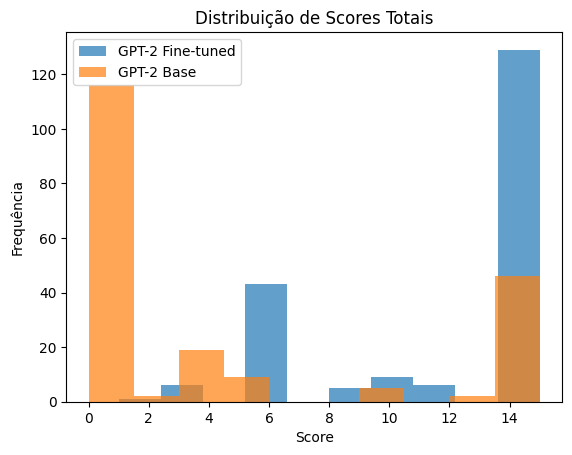

In [29]:
data = load_json("llm_judge_results.json")

totals_a = []
totals_b = []
for entry in data:
    temp = entry["judge_evaluation"]
    if "model_a" in temp.keys():
        totals_a.append(temp["model_a"]["total"])
    if "model_b" in temp.keys():
        totals_b.append(temp["model_b"]["total"])

plt.hist(totals_a, alpha=0.7, label="GPT-2 Fine-tuned")
plt.hist(totals_b, alpha=0.7, label="GPT-2 Base")
plt.legend()
plt.title("Distribuição de Scores Totais")
plt.xlabel("Score")
plt.ylabel("Frequência")
plt.show()

In [31]:
import pandas as pd

MAX_SCORE = 15.0

def to_percentage(scores):
    return [(s / MAX_SCORE) * 100 for s in scores]

# ---------- LOAD DATA ----------
full_data = load_json("llm_judge_results.json")
small_data = load_json("llm_judge_results_small.json")

# ---------- COLLECT SCORES ----------
totals_a = []
totals_b = []

for entry in full_data:
    evals = entry["judge_evaluation"]

    if "model_a" in evals:
        totals_a.append(evals["model_a"]["total"])

    if "model_b" in evals:
        totals_b.append(evals["model_b"]["total"])

totals_small = [
    entry["judge_evaluation"]["model_small"]["total"]
    for entry in small_data
]

# ---------- CONVERT TO PERCENTAGE ----------
perc_a = to_percentage(totals_a)
perc_b = to_percentage(totals_b)
perc_small = to_percentage(totals_small)

# ---------- BUILD TABLE ----------
table = pd.DataFrame({
    "Modelo": [
        "GPT-2 Base",
        "GPT-2 Fine-tuned (Full)",
        "GPT-2 Fine-tuned (Small)",
    ],
    "Score Médio (%)": [
        sum(perc_b) / len(perc_b),
        sum(perc_a) / len(perc_a),
        sum(perc_small) / len(perc_small),
    ],
    "Melhor Caso (%)": [
        max(perc_b),
        max(perc_a),
        max(perc_small),
    ],
    "Pior Caso (%)": [
        min(perc_b),
        min(perc_a),
        min(perc_small),
    ],
})

print("\nTabela Comparativa Percentual\n")
print(table.to_string(index=False))


Tabela Comparativa Percentual

                  Modelo  Score Médio (%)  Melhor Caso (%)  Pior Caso (%)
              GPT-2 Base        29.246231            100.0       0.000000
 GPT-2 Fine-tuned (Full)        80.402010            100.0       6.666667
GPT-2 Fine-tuned (Small)        56.400000            100.0       0.000000
